# Band structure calculation of hexagonal lattices

In this notebook, we demonstrate the approach for simulating band diagrams of periodic structures defined in hexagonal lattices. We will reproduce the TM band diagram calculation presented in the paper by `Tsung-li Liu, Kasey J. Russell, Shanying Cui, and Evelyn L. Hu, "Two-dimensional hybrid photonic/plasmonic crystal cavities", Optics Express, (2014).` [DOI:10.1364/OE.22.008219](https://doi.org/10.1364/oe.22.008219).

For calculating band diagrams of periodic structures in a **square** lattice, please refer to our [band diagrams for a photonic crystal slab](https://www.flexcompute.com/tidy3d/examples/notebooks/Bandstructure/) example notebook.



Due to the rectangular nature of the FDTD simulation domain, a primitive hexagonal unit cell **cannot** be represented directly; therefore, it is necessary to use a rectangular supercell of size $(a \times \sqrt{3}a$), constructed from two primitive real-space lattice vectors. However, this supercell enlarges the real-space period and reduces the Brillouin zone, which introduces artificial band folding.

To suppress these folded modes, we apply **matching dipoles**. For each dipole placed in the supercell, a second dipole is added at the position shifted by the primitive lattice vector $\vec{r}$ of the true hexagonal cell. The second dipole is driven with a Bloch phase factor  

$$e^{-i 2\pi\,\vec{b}\cdot\vec{r}}$$

where $\vec{b}$ is the Bloch wavevector. This enforces the correct Bloch periodicity of the primitive cell, ensuring that only the physical (unfolded) Bloch modes are excited, and allowing the band diagram to be computed using the standard high-symmetry points of the hexagonal Brillouin zone.

This notebook is structured as follows:

[1)](#1) Definition of the K-points for the hexagonal lattice  
[2)](#2) Supercell definition and base simulation setup  
[3)](#3) Function for creating matching dipoles for a given Bloch vector  
[4)](#4) Band diagram calculation

<center><img src="./img/HexagonalSupercell.png" width=500 /></center>

In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
from tidy3d import web

# Defining a random seed for reproducibility
np.random.seed(12)

## K-points Definition <a name="1"></a>

For a hexagonal lattice, we can define the two real-space lattice vectors as  
$a_1 = (a,\,0)$ and  
$a_2 = a(\cos(\pi/3),\,\sin(\pi/3))$.

To transform these vectors into reciprocal space, we use the standard definition, where $a_3$ is simply (0,0,1).

$b_i = 2\pi\, \frac{a_j \times a_k}{a_1 \cdot (a_2 \times a_3)}$


Hence, the vectors in the reciprocal space are:

$ b_1 = \frac{2\pi}{a}(1,-\frac{1}{\sqrt{3}}) $  
$ b_2 = \frac{2\pi}{a}(0,\frac{2}{\sqrt{3}}) $

For band calculations, we only need to sweep points in the irreducible Brillouin zone (IBZ), which in reduced reciprocal coordinates corresponds to the triangular region defined by the points

- $\Gamma = (0,\,0)$  
- $M = \left(0,\,\tfrac{1}{\sqrt{3}}\right)$  
- $K = \left(\tfrac{1}{3},\,\tfrac{1}{\sqrt{3}}\right)$.

The code below illustrates the real and reciprocal spaces.

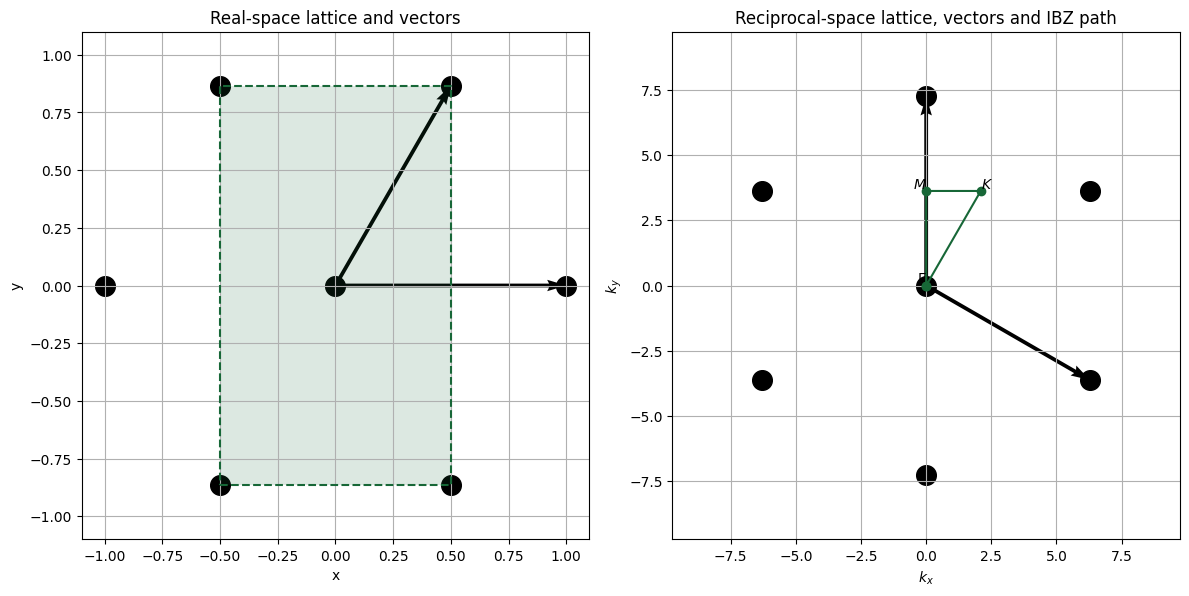

In [2]:
import numpy as np

# -------------------------------------------------
# Lattice definitions
# -------------------------------------------------
a = 1.0  # lattice constant

# Real-space lattice vectors
a1 = np.array([a, 0.0])
a2 = a * np.array([np.cos(np.pi / 3), np.sin(np.pi / 3)])

# Reciprocal-space lattice vectors
b1 = (2 * np.pi / a) * np.array([1.0, -1.0 / np.sqrt(3)])
b2 = (2 * np.pi / a) * np.array([0.0, 2.0 / np.sqrt(3)])

# -------------------------------------------------
# Generate lattice points
# -------------------------------------------------
N = 5  # number of points in each direction (odd, so we get symmetry around 0)

# Real space points
pts_real = []
for i in range(-(N // 2), N // 2 + 1):
    for j in range(-(N // 2), N // 2 + 1):
        pts_real.append(i * a1 + j * a2)
pts_real = np.array(pts_real)

# Reciprocal space points
pts_rec = []
for i in range(-(N // 2), N // 2 + 1):
    for j in range(-(N // 2), N // 2 + 1):
        pts_rec.append(i * b1 + j * b2)
pts_rec = np.array(pts_rec)


# -------------------------------------------------
# IBZ path in reciprocal space
# (given in reduced coordinates; convert to Cartesian k)
# -------------------------------------------------
Gamma = 2 * np.pi / a * np.array([0.0, 0.0])
M = 2 * np.pi / a * np.array([0.0, 1.0 / np.sqrt(3)])
K = 2 * np.pi / a * np.array([1.0 / 3.0, 1.0 / np.sqrt(3)])

ibz_path = np.vstack([Gamma, M, K, Gamma])

# -------------------------------------------------
# Plot
# -------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# --- Real space ---
ax1.scatter(pts_real[:, 0], pts_real[:, 1], marker="o", s=200, color="black")
ax1.quiver(0, 0, a1[0], a1[1], angles="xy", scale_units="xy", scale=1)
ax1.quiver(0, 0, a2[0], a2[1], angles="xy", scale_units="xy", scale=1)
ax1.set_title("Real-space lattice and vectors")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_aspect("equal")
ax1.grid(True)

# Supercell corners in real space
W = a / 2
H = (a * np.sqrt(3)) / 2

# Rectangle corners (closed loop)
rect = np.array([[-W, -H], [W, -H], [W, H], [-W, H], [-W, -H]])

# Draw rectangle
ax1.plot(rect[:, 0], rect[:, 1], "--")

# Fill it
ax1.fill(rect[:, 0], rect[:, 1], alpha=0.15)


# --- Reciprocal space ---
ax2.scatter(pts_rec[:, 0], pts_rec[:, 1], marker="o", s=200, color="black")
ax2.quiver(0, 0, b1[0], b1[1], angles="xy", scale_units="xy", scale=1)
ax2.quiver(0, 0, b2[0], b2[1], angles="xy", scale_units="xy", scale=1)

# IBZ path Γ–M–K–Γ
ax2.plot(ibz_path[:, 0], ibz_path[:, 1], marker="o")

# Label the special points
ax2.text(Gamma[0], Gamma[1], r"$\Gamma$", ha="right", va="bottom")
ax2.text(M[0], M[1], r"$M$", ha="right", va="bottom")
ax2.text(K[0], K[1], r"$K$", ha="left", va="bottom")

ax2.set_title("Reciprocal-space lattice, vectors and IBZ path")
ax2.set_xlabel(r"$k_x$")
ax2.set_ylabel(r"$k_y$")
ax2.set_aspect("equal")
ax2.grid(True)

ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(-1.1, 1.1)

ax2.set_xlim(-3.1 * np.pi / a, 3.1 * np.pi / a)
ax2.set_ylim(-3.1 * np.pi / a, 3.1 * np.pi / a)

plt.tight_layout()
plt.show()

## Simulation Setup <a name="2"></a>

Next, we will define the global parameters to be used in the simulation.
Since we can express everything in terms of the lattice constant, we will set it to 1 and then scale the frequency accordingly during post-processing.

In [3]:
# Source polarization
polarization = "Ez"

theta = np.pi / 6
sizeZ = 6

# Option to add or not add matching dipoles
matchingDipoles = True

# K-points of the Brillouin zone of the hexagonal lattice
kPoints = [(0, 0), (0, 1 / (np.sqrt(3))), (1 / 3, 1 / np.sqrt(3)), (0, 0)]

# Source frequency and width
freq0 = 200e12
fwidth = 150e12

runTime = 2e-12

rodMaterial = td.Medium(permittivity=2.5**2)

# Lattice constant defined as 1. Then we just scale the results
latticeConstant = 1

radius = 0.28 * latticeConstant
height = 1 * latticeConstant


# Lattice vectors
y = latticeConstant * np.cos(theta)
x = latticeConstant * np.sin(theta)
a1 = np.array([x, y, 0])
a2 = np.array([-x, y, 0])


# Creating the supercell
centerRod = td.Cylinder(center=(0, 0, 0), radius=radius, length=height)

geometry = centerRod
geometry += centerRod.updated_copy(center=tuple(-a1))
geometry += centerRod.updated_copy(center=tuple(a2))
geometry += centerRod.updated_copy(center=tuple(-a2))
geometry += centerRod.updated_copy(center=tuple(a1))


structure = td.Structure(geometry=geometry, medium=rodMaterial)

size = (2 * x, 2 * y, sizeZ)

To ensure periodicity, we will use a [MeshOverrideStructure](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.MeshOverrideStructure.html) to create a custom grid with a fixed number of grid points in x and y.

In [4]:
grid = td.MeshOverrideStructure(
    geometry=td.Box(center=(0, 0, 0), size=(td.inf, td.inf, td.inf)),
    dl=(size[0] / 40, size[1] / 60, 0.1),
)

grid_spec = td.GridSpec.auto(
    override_structures=[grid],
)

Next, we will define the sources and monitors.

We will place 5 sources randomly distributed in the lower-left unit cell region, and 5 [FieldTimeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldTimeMonitor.html) objects randomly distributed in the supercell.

In [5]:
# Sources
Nsources = 5

sourceTime = [
    td.GaussianPulse(freq0=freq0, fwidth=fwidth, phase=i)
    for i in 2 * np.pi * np.random.random(2 * Nsources)
]


# Random positions for the sources
posySource = np.random.uniform(-0.8, -0.2, Nsources)
posxSource = np.random.uniform(-0.2, -0.1, Nsources)


# Monitors
Nmonitors = 5

posyMon = np.random.uniform(-0.8, 0.8, Nmonitors)
posxMon = np.random.uniform(-0.2, 0.2, Nmonitors)

monitors = [
    td.FieldTimeMonitor(center=(posxMon[i], posyMon[i], 0), name=f"mon{i}", size=(0, 0, 0), start=0)
    for i in range(Nmonitors)
]

09:56:18 -03 WARNING: The monitor 'interval' field was left as its default      
             value, which will set it to 1 internally. A value of 1 means that  
             the data will be sampled at every time step, which may potentially 
             produce more data than desired, depending on the use case. To      
             reduce data storage, one may downsample the data by setting        
             'interval > 1' or by choosing alternative 'start' and 'stop' values
             for the time sampling. If you intended to use the highest          
             resolution time sampling, you may suppress this warning by         
             explicitly setting 'interval=1' in the monitor.                    

             WARNING: The monitor 'interval' field was left as its default      
             value, which will set it to 1 internally. A value of 1 means that  
             the data will be sampled at every time step, which may potentially 
             produce more data than desired, depending on the use case. To      
             reduce data storage, one may downsample the data by setting        
             'interval > 1' or by choosing alternative 'start' and 'stop' values
             for the time sampling. If you intended to use the highest          
             resolution time sampling, you may suppress this warning by         
             explicitly setting 'interval=1' in the monitor.                    

             WARNING: The monitor 'interval' field was left as its default      
             value, which will set it to 1 internally. A value of 1 means that  
             the data will be sampled at every time step, which may potentially 
             produce more data than desired, depending on the use case. To      
             reduce data storage, one may downsample the data by setting        
             'interval > 1' or by choosing alternative 'start' and 'stop' values
             for the time sampling. If you intended to use the highest          
             resolution time sampling, you may suppress this warning by         
             explicitly setting 'interval=1' in the monitor.                    

             WARNING: The monitor 'interval' field was left as its default      
             value, which will set it to 1 internally. A value of 1 means that  
             the data will be sampled at every time step, which may potentially 
             produce more data than desired, depending on the use case. To      
             reduce data storage, one may downsample the data by setting        
             'interval > 1' or by choosing alternative 'start' and 'stop' values
             for the time sampling. If you intended to use the highest          
             resolution time sampling, you may suppress this warning by         
             explicitly setting 'interval=1' in the monitor.                    

             WARNING: The monitor 'interval' field was left as its default      
             value, which will set it to 1 internally. A value of 1 means that  
             the data will be sampled at every time step, which may potentially 
             produce more data than desired, depending on the use case. To      
             reduce data storage, one may downsample the data by setting        
             'interval > 1' or by choosing alternative 'start' and 'stop' values
             for the time sampling. If you intended to use the highest          
             resolution time sampling, you may suppress this warning by         
             explicitly setting 'interval=1' in the monitor.                    

## Defining the [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) and Matching Dipoles <a name="3"></a>

Finally, we define a function to generate the [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) object as a function of the parameters below.

In [6]:
# Function to return a simulation for each Bloch vector
def getSim(pol, bloch_x, bloch_y, matchingDipoles=True):
    symmetry = [0, 0, -1] if pol == "Ez" else [0, 0, 1]

    boundary_spec = td.BoundarySpec(
        x=td.Boundary.bloch(bloch_x * size[0]),
        y=td.Boundary.bloch(bloch_y * size[1]),
        z=td.Boundary.pml(),
    )

    bVector = np.array([bloch_x, bloch_y, 0])

    # Creating the sources
    sources = [
        td.PointDipole(
            center=(posxSource[i], posySource[i], 0), polarization=pol, source_time=sourceTime[i]
        )
        for i in range(len(posxSource))
    ]

    # Creating the matching dipoles
    matching_dipoles = []
    if matchingDipoles:
        for i, sc in enumerate(sources):
            # Coordinates of the matching dipole
            px = sc.center[0] + 0.5
            py = sc.center[1] + np.sqrt(3) / 2

            # Adjust the phase
            phase = sc.source_time.phase
            r_vec = np.array((px, py, 0)) - np.array(sc.center)
            deltaPhase = 2 * np.pi * bVector.dot(r_vec)

            source_time = sc.source_time.updated_copy(phase=phase + deltaPhase)

            sp = sc.updated_copy(center=(px, py, 0), source_time=source_time)
            matching_dipoles.append(sp)

    sim = td.Simulation(
        size=size,
        structures=[structure],
        sources=sources + matching_dipoles,
        monitors=monitors,
        run_time=runTime,
        boundary_spec=boundary_spec,
        grid_spec=grid_spec,
        symmetry=symmetry,
        medium=td.Medium(),
        shutoff=False,
    )
    return sim

Now we can create a simulation object and inspect the permittivity to confirm that the periodicity is preserved.

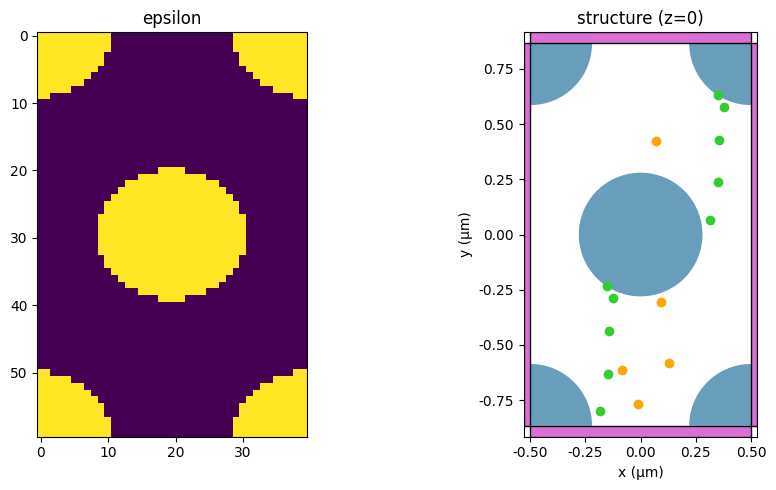

In [7]:
sim = getSim(polarization, 0, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Left: epsilon
eps = sim.epsilon(td.Box(center=(0, 0, 0), size=(99, 99, 0)))
ax1.imshow(abs(eps).squeeze().T)
ax1.set_title("epsilon")

# Right: structure
sim.plot(z=0, ax=ax2)
ax2.set_title("structure (z=0)")

plt.tight_layout()
plt.show()

Now we can interpolate points around the K-points and run a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) simulation to execute the simulations in parallel.

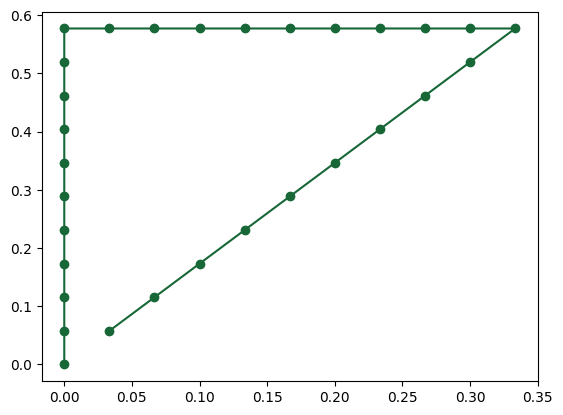

In [8]:
# Creating K points
pointsPerZone = 10

createPoints = lambda init, end: [
    init + (end - init) * i / pointsPerZone for i in range(pointsPerZone)
]

KX = []
KY = []

kx1, ky1 = kPoints[0]
for k in kPoints[1:]:
    kx2, ky2 = k
    KX += createPoints(kx1, kx2)
    KY += createPoints(ky1, ky2)
    kx1, ky1 = kx2, ky2

# Visualizing the K-points

fig, ax = plt.subplots()
ax.plot(KX, KY, "-o")


sims = {}
for i in range(len(KX)):
    for pol in [polarization]:
        sims[f"s{i}{pol}"] = getSim(pol, KX[i], KY[i])

plt.show()

In [9]:
# Running the simulations

batch = web.Batch(simulations=sims, folder_name="hexagonalBandDiagram")
batch_data = batch.run(path_dir="bandDiagram")

Output()

09:56:30 -03 Started working on Batch containing 30 tasks.

09:57:10 -03 Maximum FlexCredit cost: 0.750 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

09:57:35 -03 Batch complete.

Output()

## Band Diagram Calculation <a name="4"></a>

Now we can sum the signals from all monitors and use the
[ResonanceFinder](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.resonance.ResonanceFinder.html)
plugin to track the resonances for each simulation.

To ensure that we compute **weakly confined modes above the light cone**, we first analyze the source decay time and only use the data immediately after the decay.


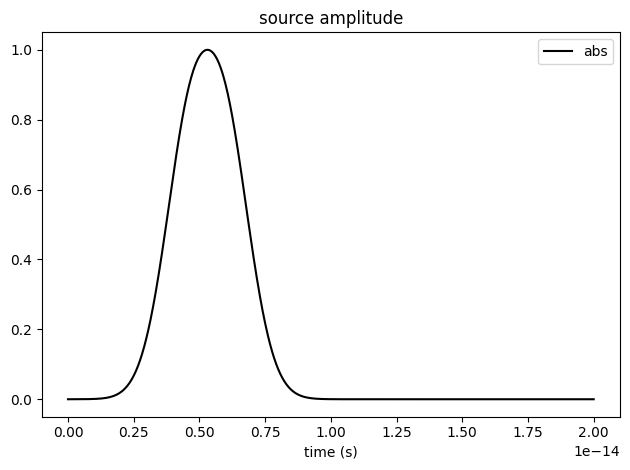

In [10]:
sim.sources[0].source_time.plot(times=np.linspace(0, 0.2e-13, 1001), val="abs")
plt.show()

In [11]:
# Sum the signals for all monitors
def getSignal(sim_data, polarization, t_start=1e-14, t_end=2e-12):
    signal = 0
    for i in range(Nmonitors):
        signal += sim_data[f"mon{i}"].field_components[polarization].squeeze()
    return signal.where(signal.t > t_start, drop=True).where(signal.t < t_end, drop=True)


from tidy3d.plugins.resonance import ResonanceFinder

# Analyzing resonances
dic = {}
for i in range(len(KX)):
    for pol in [polarization]:
        resonance_finder = ResonanceFinder(freq_window=(0e12, 200e12))
        sim_data = batch_data[f"s{i}{pol}"]
        signal = getSignal(sim_data, pol)

        resonance_data = resonance_finder.run_raw_signal(signal, sim_data.simulation.dt)
        df = resonance_data.to_dataframe()
        dic[f"s{i}{pol}"] = df

Finally, we can plot the band diagram. 
To match the results with the [reference paper](https://www.flexcompute.com/tidy3d/examples/notebooks/Bandstructure/), we will multiply the frequencies by four, since the original lattice constant is 0.25 µm.

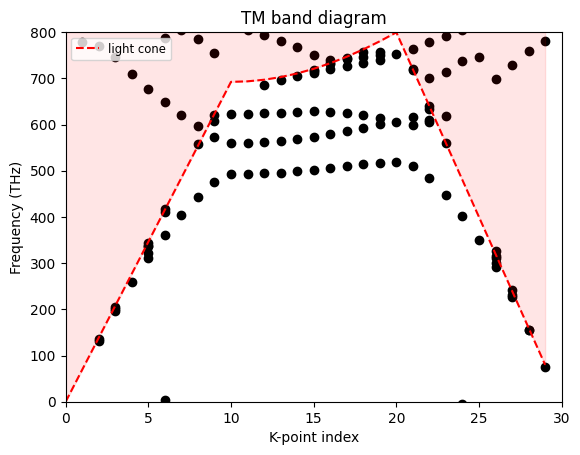

In [12]:
# Scale factor
scaleFactor = 4

fig, ax = plt.subplots()

for name, df in dic.items():
    pos = int(name[1:-2])
    df = df[df["error"] < 2]
    sct = ax.scatter(x=np.repeat(pos, len(df)), y=df.index * scaleFactor * 1e-12, color="black")

# Light cone overlay (air background; ± branches)
idx = np.arange(len(KX))
# Convert reduced coordinates to |k| in m^-1
k_mag = (2 * np.pi / latticeConstant) * np.sqrt(np.array(KX) ** 2 + np.array(KY) ** 2)
# Frequency in THz: f = c |k| / (2π)
f_light_thz = (td.constants.C_0 * k_mag / (2 * np.pi)) / 1e12
ax.plot(idx, scaleFactor * f_light_thz, "r--", label="light cone")
ax.fill_between(idx, scaleFactor * f_light_thz, 800, color="red", alpha=0.1)

ax.set_ylim(0, 800)
ax.set_xlim(0, len(KX))
ax.set_ylabel("Frequency (THz)")
ax.set_xlabel("K-point index")
ax.set_title("TM band diagram")

ax.legend(loc="upper left", fontsize="small")

plt.show()